In [1]:
%load_ext autoreload
%autoreload 2

import cPickle, os, sys
import random
sys.path.insert(1, os.path.join(sys.path[0], '..'))

from ddlite import *

# Importing documents

In [2]:
#Thomas data folder 
# DATA_FOLDER='/Users/thomaspalomares/Desktop/Stanford/RA/multisentences/data/'
#Tanya data folder
# DATA_FOLDER='/Users/tanyaberardini/Desktop/DeepDive/data/'
DATA_FOLDER='arabidopsis_data/'

In [3]:
import json

In [4]:
# #To be modified to conserve correct doc_ids (in particular, write in different txt files)
# nb_lines=0
# nb_error_parsing=0
# with open(DATA_FOLDER+'pmc/json/output_plant.json', 'rb') as json_file:
#     with open(DATA_FOLDER+'pmc/text/output_plant.text', 'wb') as text_write:
#         docs={}
#         for line in json_file:
#             nb_lines+=1
#             doc_id_read=str(json.loads(line)['doc-id'].encode('utf-8').strip())
# #             try:
#             #Because this doc is too big
#             if doc_id_read=='10.1093.jxb.eru198':
#                 if random.random() <0.5:
#                     doc_id_read += '_1'
#                 else:
#                     doc_id_read += '_2'
#             if doc_id_read in docs:
#                 docs[doc_id_read] += unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + '.\n', errors='ignore')
#             else:
#                 docs[doc_id_read] = unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + '.\n', errors='ignore')
# #                 text_write.write(unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + '.\n', errors='ignore'))
# #             except:
# #                 nb_error_parsing +=1
# #                 print "error parsing"
# print nb_lines
# print nb_error_parsing

In [5]:
# test = SentenceParser()
# test.parse(docs)
# # dp = DocParser(DATA_FOLDER + 'pmc/text/', TextParser())

In [6]:
pkl_f=DATA_FOLDER+'pmc/pickle/pkl_sentences'
sents=[]
count_loop=0
try:
    with open(pkl_f, 'rb') as f:
        sents = cPickle.load(f)
except:
    print"parsing data"
    for doc_id_loop in docs:
        count_loop+=1
        print count_loop
        for j in test.parse(docs[doc_id_loop], doc_id=doc_id_loop):
            sents.append(j)
    with open(pkl_f, 'w+') as f:
        cPickle.dump(sents, f)

In [7]:
print sents[1]

Sentence(words=[u'It', u'Takes', u'Two', u'to', u'Tango', u':', u'A', u'New', u'Partner', u'in', u'Amylose', u'Synthesis', u'.'], lemmas=[u'it', u'take', u'two', u'to', u'Tango', u':', u'A', u'New', u'Partner', u'in', u'Amylose', u'synthesis', u'.'], poses=[u'PRP', u'VBZ', u'CD', u'TO', u'NNP', u':', u'NNP', u'NNP', u'NNP', u'IN', u'NNP', u'NN', u'.'], dep_parents=[2, 0, 2, 5, 2, 5, 9, 9, 5, 12, 12, 9, 2], dep_labels=[u'nsubj', u'ROOT', u'dobj', u'case', u'nmod', u'punct', u'compound', u'compound', u'dep', u'case', u'compound', u'nmod', u'punct'], sent_id=1, doc_id='PBIOLOGY-D-14-02490', text=u'It Takes Two to Tango: A New Partner in Amylose Synthesis.', token_idxs=[153, 156, 162, 166, 169, 174, 176, 178, 182, 190, 193, 201, 210])


In [8]:
#Think about how to add doc_ids. 
#In particular, look at the small code in parseDocSentences()
# %time sents = dp.parseDocSentences()
# print sents[0]

# Candidate mention Extraction

## Gene extraction

In [9]:
#What is the exact schema of genes ?
genes=[]
for row_genes in [line.rstrip().split('\t') for line in open(DATA_FOLDER + '/dicts/list_genes.txt')]:
    for gene in row_genes:
        genes.append(gene)
        
#Removing blacklist_words
blacklist_words = [line.rstrip().split('\t')[1].lower() for line in open(DATA_FOLDER + '/dicts/blacklist_words.txt')][1:]
genes_filtered = [x.lower() for x in genes if x.lower() not in blacklist_words]

gene_dm = DictionaryMatch(label='GeneName', dictionary=genes_filtered, ignore_case=False)

The dictionary match should provide fairly high recall, but we may still miss some candidates. We know that gene names are named nouns and are often all uppercase. Let's use DDLite's compositional matcher operations to handle this. First, we'll write a matcher to find all nouns using the parts-of-speech tags. Then, we'll use a filter to find uppercase sequences. Finally, we'll use a filter to make sure each match has at least 3 characters. We pass noun_rm to up_rm, and up_rm to the final filter to compose them with each other.

In [10]:
noun_regex = RegexNgramMatch(label='Nouns', regex_pattern=r'[A-Z]?NN[A-Z]?', ignore_case=True, match_attrib='poses')
up_regex = RegexFilterAll(noun_regex, label='Upper', regex_pattern=r'[A-Z]+([0-9]+)?([A-Z]+)?([0-9]+)?$', ignore_case=False, match_attrib='words')
multi_regex = RegexFilterAll(up_regex, label='Multi', regex_pattern=r'[a-z0-9]{3,}', ignore_case=True)

Since we want matches both from the dictionary and the uppercase-noun-phrase-matcher we just built, we'll use the union object to create a matcher for both.

In [11]:
#The previous regexes seem to catch many patterns not wanted (like 'and' or others), let's ignore it for now and we can add it when we'll work on recall
# GM = Union(gene_dm, multi_regex)
GM=gene_dm

## Pheno extraction

In [12]:
# Schema is: HPO_ID | NAME | TYPE (exact, lemma)
phenos_deepdive = [line.rstrip().split('\t')[1] for line in open(DATA_FOLDER + '/dicts/pheno_terms.tsv')]
phenos_arabidopsis = [line.rstrip() for line in open(DATA_FOLDER + '/dicts/list_phenotypes_arabidopsis_filtered.txt')]
phenos_worm_variants = [line.rstrip() for line in open(DATA_FOLDER + '/dicts/worm_variants_unix.txt')]
phenos_all_eq_dict = [pheno.strip() for line in open(DATA_FOLDER + 'dicts/phenotypes_all_eq_dict.txt') for pheno in line.rstrip().split(';')]
phenos_manual = [line.rstrip() for line in open(DATA_FOLDER + '/dicts/phenotypes_manual.txt')]

phenos_tot = phenos_deepdive + phenos_arabidopsis + phenos_worm_variants + phenos_all_eq_dict + phenos_manual

#Removing the phenotypes that are in the blacklist.
blacklist_words = [line.rstrip().split('\t')[1].lower() for line in open(DATA_FOLDER + '/dicts/blacklist_words.txt')][1:]
phenos_tot_filtered = [x.lower() for x in phenos_tot if x.lower() not in blacklist_words]

PM = DictionaryMatch(label='PhenoName', dictionary=phenos_tot_filtered)

# Relation Extraction

For each sentence, we extract a candidate relation for each pair (gene, phenotype) appearing in the sentence.

In [13]:
R = Relations(sents, GM, PM)

In [14]:
R[0].render()

<!--Provide the canvas id (twice) and the words via python string formatting here--!>
 
 
 While _ dpe1 _ mutants also have a mild impairment in the rate of starch degradation , the primary reason for its high amylose content ( over 20 % of granule mass ; see ) is the accumulation of short malto-oligosaccharides , which can act as primers for GBSS activity -LSB- , -RSB- .

In [15]:
# test_sent=9
# for i in range(len(R[test_sent].dep_parents)):
#     print i, R[test_sent].words[i], R[test_sent].dep_parents[i], R[test_sent].poses[i]

In [16]:
# R.dump_candidates('pickle/relations.pkl')

# ddlite Model

We create a ddlite model from the previous candidates, on which we will extract features, define labeling functions and learn a model. 

In [41]:
DDL = DDLiteModel(R)
print "Extracted {} features for each of {} mentions".format(DDL.num_feats(), DDL.num_candidates())

Extracted 25832 features for each of 925 mentions


# Building a gold ground truth

We label here a certain amount of sentences that will allow us to evaluate our model.

In [18]:
#Complete random set of gold truth elements, just to make the learning work
gold = np.zeros((DDL.num_candidates()))
gold[np.array([68,69,70,71,72,73,74,75,76,78,79,80,81,82,83,84,85,86,88,89,90,91])] = np.array([
     1,1,1,-1,1,-1,-1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,1,1,1])
DDL.set_gold_labels(gold)
DDL.set_holdout(p=0.5)

../ddlite.py:748: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.validation = h[ : np.floor(p * len(h))]
../ddlite.py:749: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  self.test = h[np.floor(p * len(h)) : ]


In [19]:
#Yellow: gene. Blue: phenotype
DDL.open_mindtagger(num_sample=200, width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


In [20]:
# DDL.add_mindtagger_tags()
# DDL.get_ground_truth()

# Writing labeling functions

We'll use data programming to learn a logistic regression model which will predict the probability of a candidate entity being a true gene mention. Since our training data is not manually labeled, we'll generate many (potentially noisy) labels as a surrogate for precise, manual labels. Feature extraction and model learning are very simple in ddlite. Writing labeling functions is where the real artistry comes in. One of ddlite's goals is to enable rapid prototyping, debugging, and experimenting with labeling functions. These can be used either to create a simple standalone app, or to plug into DeepDive. Labeling functions, or LFs, are functions that take an Candidate object. They must return 1 (for a positive label), 0 (for abstaining), or -1 (for a negative example). For now, we'll write a few simple LFs to get started:

In [21]:
#Here, idx_mention refers to 0 or 1, whether we consider the gene or phenotype
def post_window(r, idx_mention, key, n=3):
    s = list(r.all_idxs[idx_mention])
    b = len(r.lemmas) - np.max(s)
    s.extend([np.max(s) + i for i in range(1, min(b,n+1))])
    return key in [r.lemmas[i] for i in s]
def pre_window (r, idx_mention, key, n=3):
    s = list(r.all_idxs[idx_mention])
    b = np.min(s)
    s.extend([b - i for i in range(1, min(b,n+1))])
    return key in [r.lemmas[i] for i in s]
def stopper(r, idx_mention, stop):
    return stop in [r.lemmas[i] for i in r.all_idxs[idx_mention]]

#If the word mutation is before gene:
def LF_mutation_gene_t(r):
    return 1 if 'mutation' in [r.lemmas[r.dep_parents[i]-1] for i in r.all_idxs[0]] else 0
#If the word mutation is before pheno:
def LF_mutation_pheno_t(r):
    return 1 if 'mutation' in [r.lemmas[r.dep_parents[i]-1] for i in r.all_idxs[1]] else 0
#If phenotype just before gene, certainly wrong
def LF_pheno_before_gene_f(r):
    res=False
    for i in r.all_idxs[1]:
        if pre_window(r, 0, r.words[i], n=1):
            res=True
    if res:
        return -1
    else:
        return 0
#If phenotype is only a verb, likely to be false
def LF_pheno_only_verb_f(r):
    if len(r.all_idxs[1])==1 and r.poses[r.all_idxs[1][0]][0:2] == 'VB':
        return -1
    else:
        return 0
#if phenotype only one word, likely to be false (except lethal)
def LF_pheno_only_one_word_f(r):
    if len(r.all_idxs[1])==1 and r.lemmas[r.all_idxs[1][0]] != 'lethal':
        return -1
    else:
        return 0
#if gene and phenotype have words in common, very likely to be false
def LF_gene_pheno_words_in_common_f(r):
    if len([val for val in r.all_idxs[0] if val in r.all_idxs[1]]) >0:
        return -1
    else:
        return 0
#if gfp at the end of a gene, likely to be false
def LF_gene_ends_in_gfp_f(r):
    if len(r.all_idxs[0])==1 and len(r.mention1()[0]) >2 and r.mention1()[0][-3:].lower() == 'gfp':
        return -1
    else:
        return 0
#If double mutant around the gene name, more likely true:
def LF_double_mutant_gene_t(r):
    if (post_window(r, 0, 'double', 3) and post_window(r, 0, 'mutant', 3)) or (pre_window(r, 0, 'double', 3) and pre_window(r, 0, 'mutant', 3)):
        return 1
    else:
        return 0
#'In WT' is generally not a phenotype
def LF_in_WT_pheno_f(r):
    if len(r.all_idxs[1])==1 and r.words[r.all_idxs[1][0]] == 'WT' and pre_window(r,1, 'in', 1):
        return -1
    else:
        return 0


In [42]:
LFs= [LF_mutation_gene_t, LF_mutation_pheno_t, LF_pheno_before_gene_f, LF_pheno_only_verb_f, LF_pheno_only_one_word_f, LF_gene_pheno_words_in_common_f, LF_gene_ends_in_gfp_f, LF_double_mutant_gene_t, LF_in_WT_pheno_f]
DDL.apply_lfs(LFs, clear=True)

### More analysis on the labeling functions

In [43]:
DDL.print_lf_stats()

LF stats on dev set
Coverage:	74.486%
Overlap:	8.973%
Conflict:	2.811%


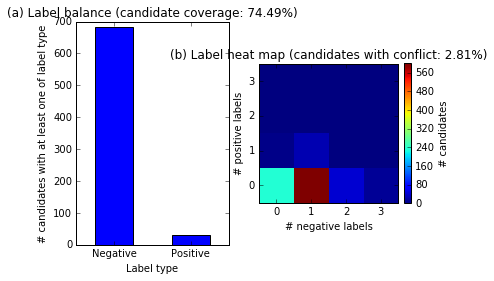

In [44]:
DDL.plot_lf_stats()

In [45]:
DDL.top_conflict_lfs(n=3)

Labeling function,Fraction of candidates where LF has conflict
LF_pheno_only_one_word_f,0.028
LF_mutation_gene_t,0.018
LF_double_mutant_gene_t,0.009


In [46]:
DDL.lowest_coverage_lfs(n=15)

Labeling function,Fraction of abstained votes
LF_gene_ends_in_gfp_f,1.000
LF_mutation_pheno_t,0.999
LF_in_WT_pheno_f,0.989
LF_pheno_only_verb_f,0.989
LF_double_mutant_gene_t,0.987
LF_mutation_gene_t,0.981
LF_gene_pheno_words_in_common_f,0.962
LF_pheno_before_gene_f,0.955
LF_pheno_only_one_word_f,0.290


In [47]:
DDL.lowest_empirical_f1_lfs(n=10)

Labeling function,Empirical LF F1 score
LF_mutation_gene_t,0.000 (n=0)
LF_pheno_before_gene_f,0.000 (n=0)
LF_gene_pheno_words_in_common_f,0.000 (n=0)
LF_gene_ends_in_gfp_f,0.000 (n=0)
LF_mutation_pheno_t,0.000 (n=0)
LF_in_WT_pheno_f,0.000 (n=0)
LF_double_mutant_gene_t,0.000 (n=0)
LF_pheno_only_verb_f,0.000 (n=0)
LF_pheno_only_one_word_f,0.000 (n=0)


In [48]:
#Let's have a look at the labeled elements:
DDL.get_labeled_ground_truth(gt='resolve', subset=None)

(array([], dtype=int64), array([], dtype=float64))

# Learning

In [51]:
matplotlib.rcParams['figure.figsize'] = (12,4)
%time DDL.learn_weights(sample=False, maxIter=500, alpha=0.5, verbose=True, plot=True, log=True)

Learning epoch =  0	100	SGD converged for mu=0.010 after 140 steps


IndexError: arrays used as indices must be of integer (or boolean) type

In [ ]:
%matplotlib inline
DDL.plot_calibration()

# Iterating with labeling functions

In [31]:
DDL.show_log()

ID,# LFs,# ground truth,Precision,Recall,F1
0,9,11,0.455,1.000,0.625


In [32]:
DDL.open_mindtagger(width='100%', height=1200)

Making sure MindTagger is installed. Hang on!


# Attempt with multi sentences

Here we concatenante 2 sentences in a same document, then export all the relations from this new dataset and keep only the candidates that have a "." between them.

First basic version when some end of sentences "." are replaced by ";" to easily have candidates covered in multisentences.

In [33]:
# #To be modified to conserve correct doc_ids (in particular, write in different txt files)
# nb_lines=0
# nb_error_parsing=0
# with open(DATA_FOLDER+'pmc/json/output_plant.json', 'rb') as json_file:
#     with open(DATA_FOLDER+'pmc/text/output_plant.text', 'wb') as text_write:
#         docs_multisentences={}
#         for line in json_file:
#             nb_lines+=1
#             doc_id_read=str(json.loads(line)['doc-id'].encode('utf-8').strip())
# #             try:
#             #Because this doc is too big
#             if doc_id_read=='10.1093.jxb.eru198':
#                 if random.random() <0.5:
#                     doc_id_read += '_1'
#                 else:
#                     doc_id_read += '_2'
#             if doc_id_read in docs_multisentences:
#                 if random.random() < 0.5:
#                     docs_multisentences[doc_id_read] += unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + '.\n', errors='ignore')
#                 else:
#                     docs_multisentences[doc_id_read] += unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + ';\n', errors='ignore')
#             else:            
#                 if random.random() < 0.5:
#                     docs_multisentences[doc_id_read] = unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + '.\n', errors='ignore')
#                 else:
#                     docs_multisentences[doc_id_read] = unicode(str(json.loads(line)['content'].encode('utf-8').strip()) + ';\n', errors='ignore') 

                    
# print nb_lines
# print nb_error_parsing

In [34]:
# pkl_f=DATA_FOLDER+'pmc/pickle/pkl_sentences_multi'
# sents_multi=[]
# count_loop=0
# try:
#     with open(pkl_f, 'rb') as f:
#         sents_multi = cPickle.load(f)
# except:
#     print"parsing data"
#     for doc_id_loop in docs:
#         count_loop+=1
#         print count_loop
#         for j in test.parse(docs_multisentences[doc_id_loop], doc_id=doc_id_loop):
#             sents_multi.append(j)
#     with open(pkl_f, 'w+') as f:
#         cPickle.dump(sents_multi, f)

In [35]:
# print sents_multi[0]

In [36]:
# R_multi = Relations(sents_multi, GM, PM)

In [37]:
# DDL_multi = DDLiteModel(R_multi)
# print "Extracted {} features for each of {} mentions".format(DDL_multi.num_feats(), DDL_multi.num_candidates())

In [38]:
# DDL_multi.open_mindtagger(num_sample=200, width='100%', height=1200)